In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from grouper import group_by_volume, group_by_time
from pyfolio.timeseries import perf_stats
from functools import partial
from utils import chart_price, plot, perf, v_backtester, c_backtester, perf_var
import sys
from functools import partial
sys.path.append('/home/tomek/ib_tools')
from indicators import get_ATR, get_signals
from candlesticks import candlesticks
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
time_int = 30
periods = 100
#multi_periods = [5, 10, 20, 40, 80, 160, 320, 3500, 7000, 14000, 28000, 46000]
multi_periods = [5, 10, 20, 40, 80,  ]
roc_periods = [2, 5, 10]
multiplier = 20
bankroll = 15000
vol_lookback = 200
smooth = int(np.ceil(periods/4))
atr_periods = 80

In [3]:
contract = pd.read_pickle('data/minute_ES_cont_non_active_included.pickle')
contract = contract.loc['20190101':'20191231']
#contract = contract.loc['20190401':]
#contract = contract.loc['20180202': '20180630']
#contract = contract.loc['20190101': '20190410']

In [4]:
vols = pd.DataFrame({'close': contract.close,})
vols['returns'] = vols['close'].pct_change()
vols['vol_returns'] = vols['returns'].ewm(span=vol_lookback, min_periods=int(vol_lookback*.9)).std()
vols['vol_price'] = vols['vol_returns'] * vols['close']
vols['vol_price_alt'] = vols['close'].ewm(span=vol_lookback, min_periods=int(vol_lookback*.9)).std()

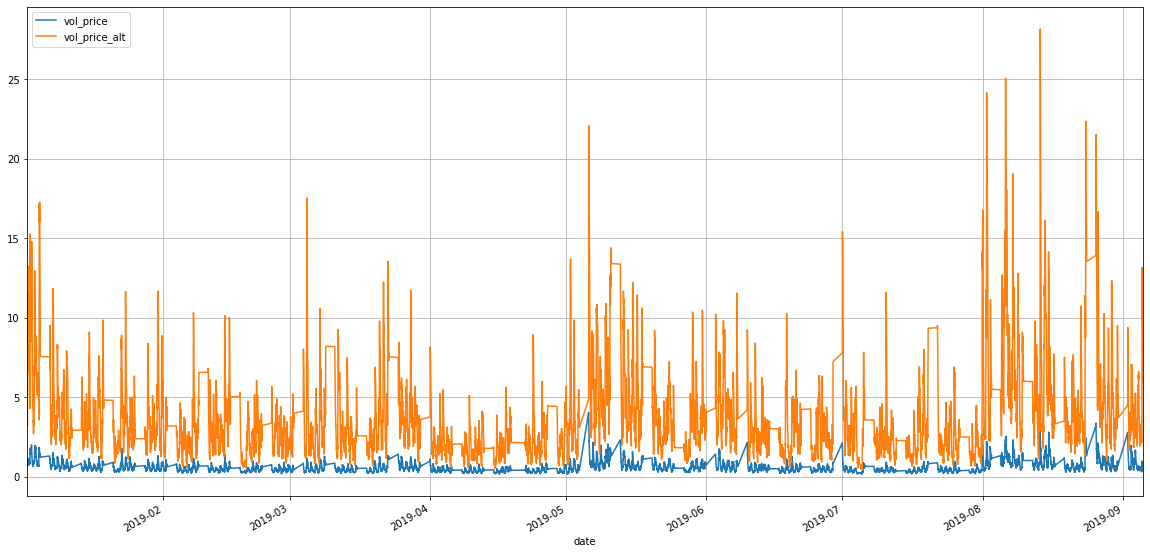

In [5]:
vols[['vol_price', 'vol_price_alt']].plot(figsize=(20,10), grid=True);

In [6]:
#avg_vol = contract.loc['20190621':].volume.rolling(time_int).sum().mean()
avg_vol = contract.volume.rolling(time_int).sum().mean()
avg_vol

31026.176951223097

In [7]:
vol_candles = group_by_volume(contract, avg_vol)
vol_candles['atr'] = get_ATR(vol_candles, atr_periods)

In [8]:
data = pd.DataFrame({'date': vol_candles.date,
                     'open': vol_candles.open,
                     'close': vol_candles.close})

In [9]:
def carver(data, periods, smooth, *args):
    data = data.copy()
    data['max'] = data.close.rolling(periods).max()
    data['min'] = data.close.rolling(periods).min()
    data['mid'] = data[['min', 'max']].mean(axis=1)
    data['breakout'] = data['close'] - data['mid']
    data['breakout_norm'] = data['breakout'] / (data['max'] - data['min'])
    data[f'breakout_{periods}'] = data['breakout_norm'].ewm(span=smooth).mean()
    return data[f'breakout_{periods}']

In [10]:
def ema(data, periods, smooth, vol):
    data = data.copy()
    data['ema_fast'] = data.close.ewm(span=periods).mean()
    data['ema_slow'] = data.close.ewm(span=periods*3).mean()
    data['ema_diff'] = data.ema_fast - data.ema_slow
    data['ema_diff_norm'] = data.ema_diff / vol
    #data['ema_diff_norm'] = data.ema_diff / data.ema_diff.rolling(periods).std()
    data[f'ema_{periods}'] = data['ema_diff_norm'].ewm(span=smooth).mean()
    return data[f'ema_{periods}']

In [11]:
def breakout(data, periods, smooth, *args):
    """
    this doesn't belong here
    """
    data = data.copy()
    data['max'] = data.close.rolling(periods).max()
    data['min'] = data.close.rolling(periods).min()
    data['mid'] = data[['min', 'max']].mean(axis=1)
    data['breakout'] = data['close'] - data['mid']
    data['breakout_norm'] = data['breakout'] / data['breakout'].rolling(periods).std()
    data[f'breakout_{periods}'] = data['breakout_norm'].ewm(span=smooth).mean()
    return data[f'breakout_{periods}']

In [12]:
def diff(data, periods, smooth, vol):
    data = data.copy()
    data['diff'] = data.close.diff(periods)
    data[f'diff_{periods}'] = data['diff'].ewm(span=smooth).mean()
    return data[f'diff_{periods}']

In [13]:
def vol(data, vol_lookback):
    data = data.copy()
    data['returns'] = data['close'].pct_change()
    data['vol_returns'] = data['returns'].ewm(span=vol_lookback, min_periods=int(vol_lookback*.9)).std()
    data['vol_price'] = data['vol_returns'] * data['close']
    return data['vol_price']

In [14]:
vols = vol(data, vol_lookback)

In [15]:
def combine(data, multi_periods, smooth, vol, funcs):
    result = pd.DataFrame()
    for func in funcs:
        result[func.__name__] = pd.DataFrame([func(data, p, smooth, vol) for p in multi_periods]).T.mean(axis=1)
    return result

In [16]:
forecasts = combine(data, multi_periods, smooth, vols, [carver, ema])
forecasts['diff'] = pd.DataFrame([diff(data, p, smooth, vol) for p in roc_periods]).T.mean(axis=1)

In [17]:
forecasts.tail()

,carver,ema,diff
label,,,
7330,0.353031,1.746681,5.428920
7331,0.364336,1.831759,7.286951
7332,0.374313,1.933931,8.463596
7333,0.379366,2.041142,9.197166
7334,0.358583,2.132395,9.124307


In [18]:
data = data.join(forecasts)
data = data.iloc[200:]

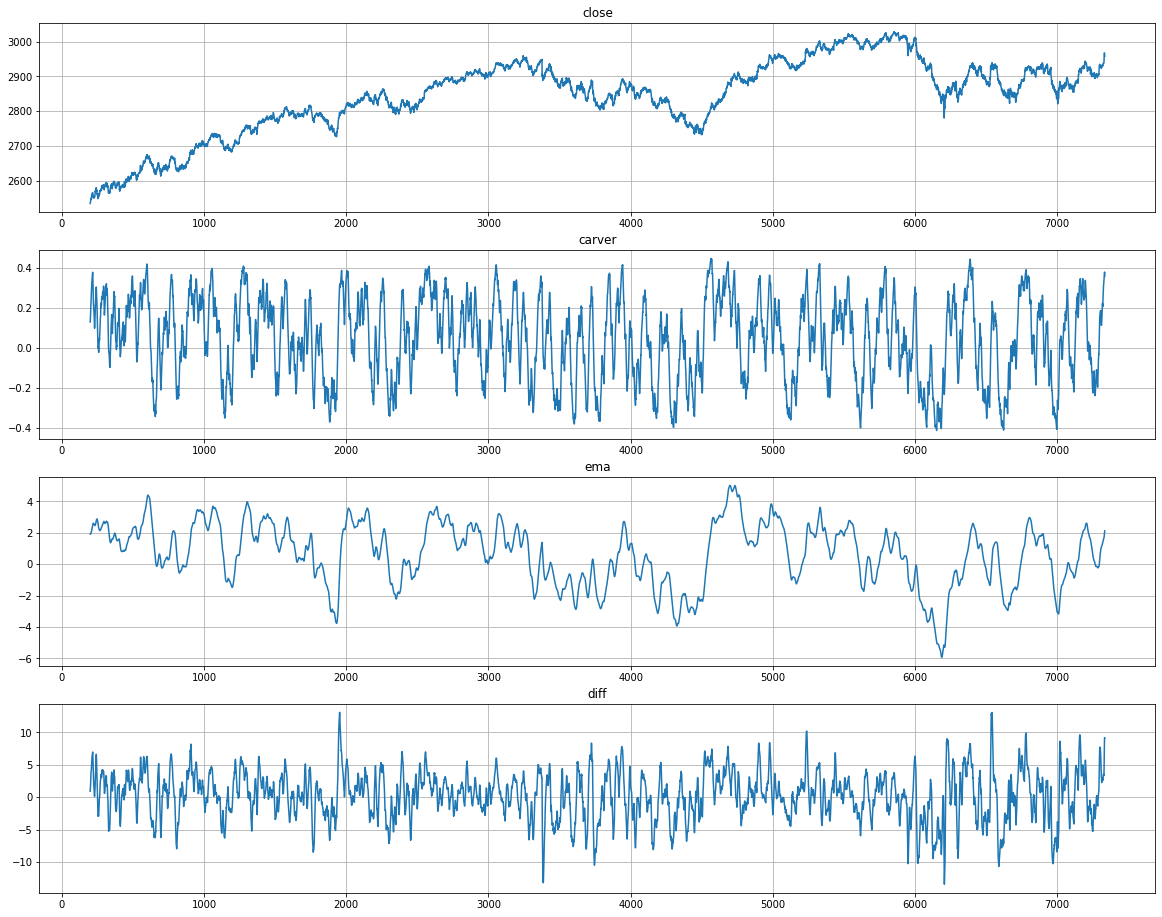

In [19]:
plot(data[['close', 'carver', 'ema', 'diff']])

In [20]:
10 / data[['carver', 'ema', 'diff']].abs().mean()

carver    56.450446
ema        5.709430
diff       3.490927
dtype: float64

In [21]:
scaled = pd.DataFrame({'date': data.date,
                       'open': data.open,
                       'close': data.close,
                       'carver': (data.carver * 20).clip(lower=-20, upper=20),
                       #'breakout': (data.breakout * 8.7).clip(lower=-20, upper=20),
                       'ema': (data.ema * 5).clip(lower=-20, upper=20),
                       #'diff': (data['diff'] * 3).clip(lower=-20, upper=20)
                      }
                     )

In [22]:
scaled['combined'] = scaled[['carver', 'ema',]].mean(axis=1)

In [23]:
scaled['combined'].std()

6.256216431452348

In [24]:
10 / scaled['combined'].std()

1.598410174834465

In [25]:
scaled['combined'] = scaled['combined'] *1.7

In [26]:
scaled[['carver', 'ema', ]].corr()

,carver,ema
carver,1.000000,0.617532
ema,0.617532,1.000000


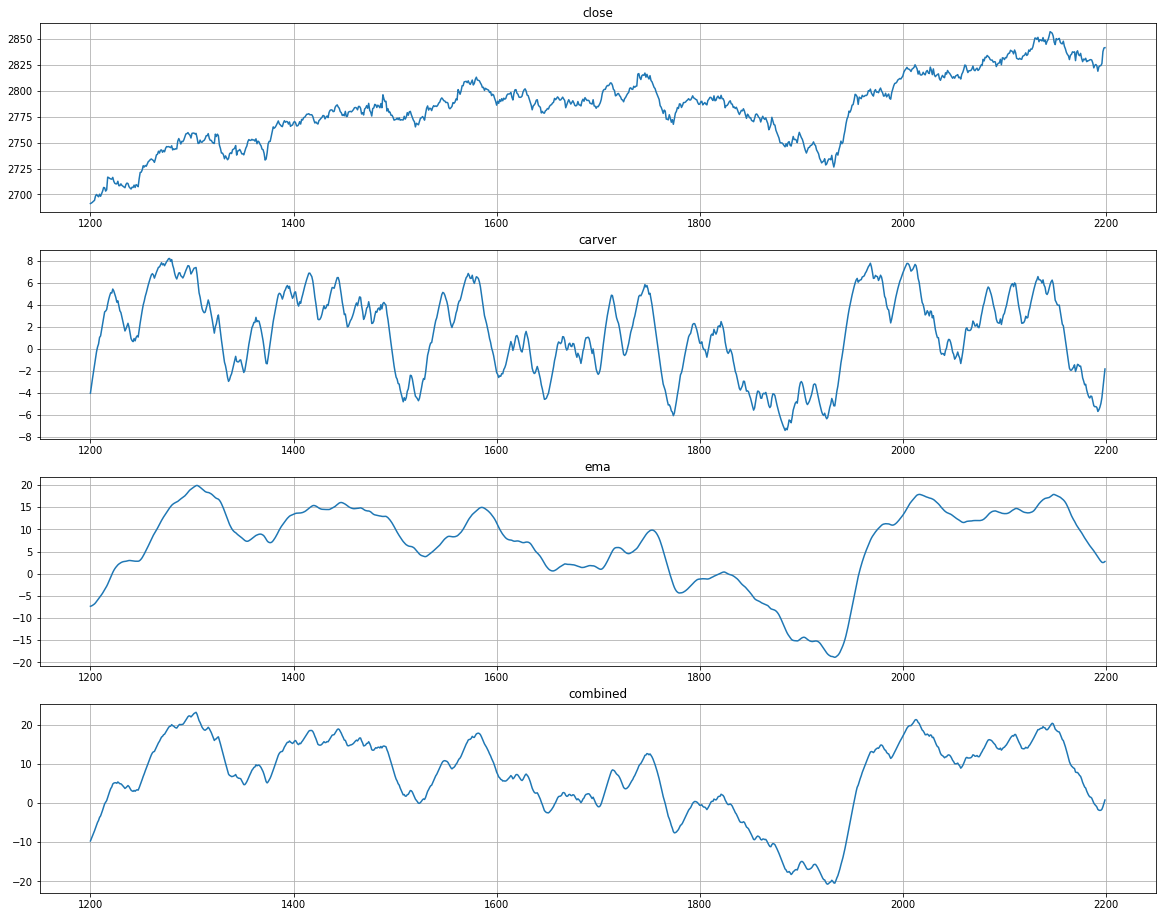

In [27]:
plot(scaled[['close', 'carver', 'ema', 'combined']].iloc[1000:2000])

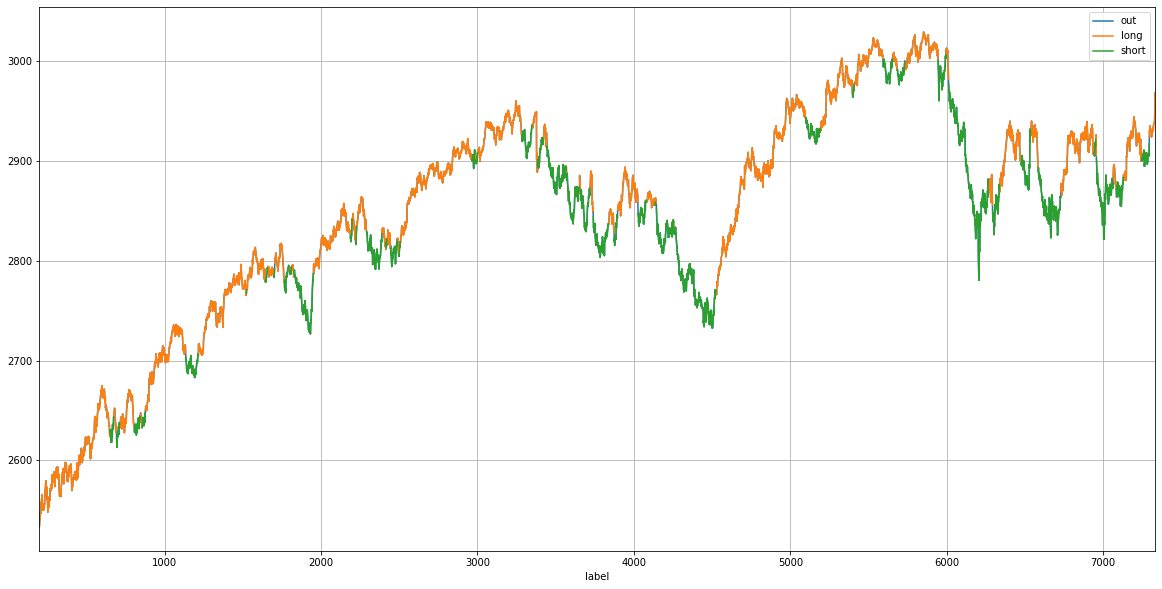

In [28]:
scaled_reindexed = scaled.set_index('date')
chart_price(scaled.close, scaled['combined'], 0);

In [29]:
stats = pd.DataFrame()
dailys = pd.DataFrame()
returns = pd.DataFrame()
for i in [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 15, ]:
    b = v_backtester(scaled_reindexed.open, scaled_reindexed.combined, i)
    r = perf_var(b, False)
    stats[i] = r.stats
    dailys[i] = r.daily.balance
    returns[i] = r.daily['returns']

In [30]:
stats

,0,1,2,3,4,5,6,7,8,10,15
Annual return,0.0311137,0.0233795,0.0658468,0.0443313,0.0288202,0.0440434,0.0450511,0.0662814,0.0898286,0.0483642,-0.0451397
Cumulative returns,0.0215054,0.0161784,0.0452797,0.030581,0.019927,0.0303837,0.0310743,0.0455756,0.0615567,0.0333432,-0.0315675
Annual volatility,0.131819,0.132006,0.12817,0.123332,0.121613,0.116956,0.108704,0.10351,0.095142,0.0873942,0.0503909
Sharpe ratio,0.29796,0.240734,0.56135,0.413019,0.294077,0.42662,0.459284,0.671389,0.951338,0.583645,-0.891648
Calmar ratio,0.24812,0.201479,0.632756,0.459035,0.27514,0.477934,0.59254,1.03405,2.23573,0.806251,-0.951311
Stability,0.000356357,0.0213457,0.0126877,9.4119e-09,0.000317966,0.00372856,0.0338822,0.230926,0.420615,0.0108404,0.212968
Max drawdown,-0.125398,-0.11604,-0.104064,-0.096575,-0.104748,-0.0921537,-0.0760306,-0.0640989,-0.0401786,-0.0599866,-0.0474499
Omega ratio,1.05161,1.04243,1.10263,1.07515,1.05315,1.08092,1.08537,1.13312,1.19809,1.12686,0.786024
Sortino ratio,0.423475,0.336629,0.797902,0.596608,0.423553,0.625887,0.706004,1.04486,1.59907,1.0165,-1.50127
Skew,0.0617146,-0.0762952,-0.106027,0.0928903,0.0938145,0.267446,0.668104,0.683278,1.23538,1.82496,2.88657


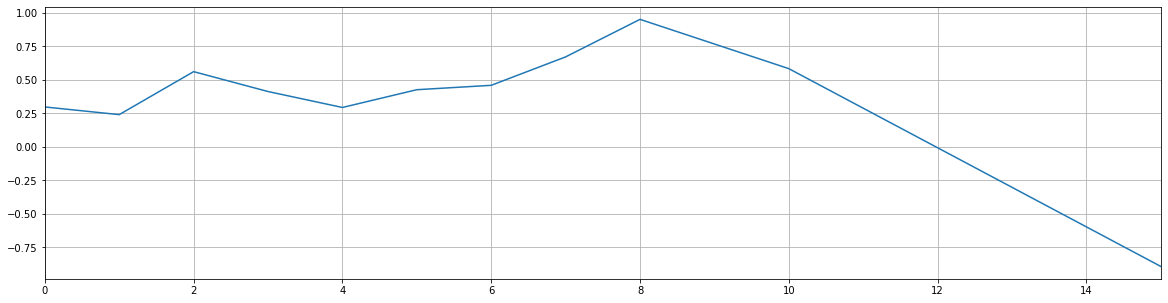

In [31]:
stats.loc['Sharpe ratio',].plot(figsize=(20,5), grid=True);

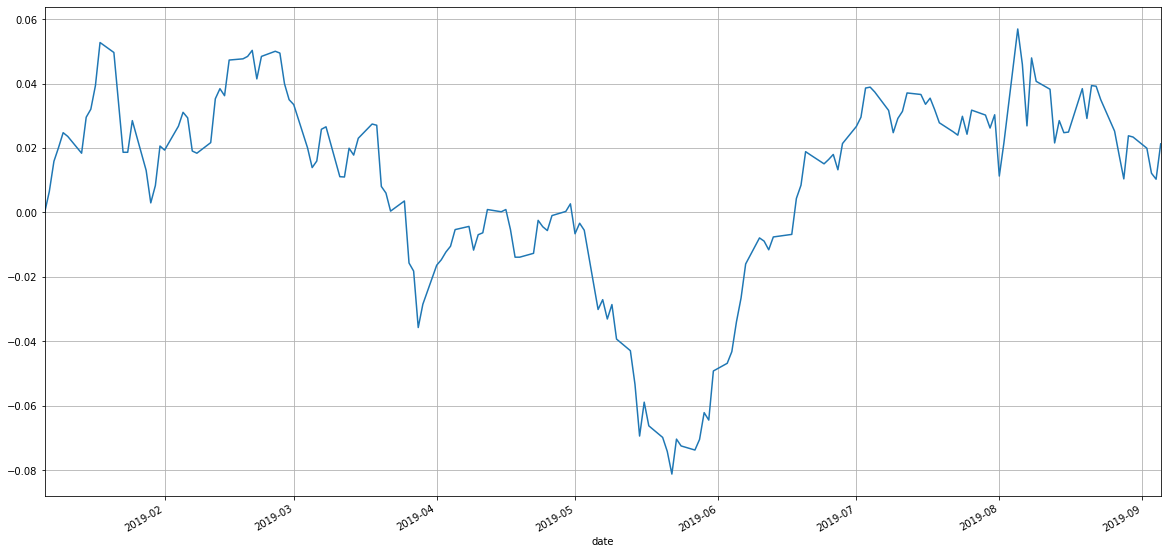

In [32]:
np.log(returns[0]+1).cumsum().plot(figsize=(20, 10), grid=True);